## **Importing Relevant Libraries**

In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import re
import string

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from plotly.offline import iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from textblob import TextBlob

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning libraries
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, auc
from sklearn import metrics

# Miscellaneous libraries
from collections import Counter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.text import hashing_trick

# XGBoost and Random Forest
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Set matplotlib figure size
plt.rcParams['figure.figsize'] = [10, 5]

# Configure cufflinks
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## **Connecting to the Google drive and download data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fake_info = pd.read_csv("/content/drive/MyDrive/fake_news_classifier/data/Fake.csv", error_bad_lines=False)

In [ ]:
true_info = pd.read_csv("/content/drive/MyDrive/fake_news_classifier/data//True.csv", error_bad_lines=False)

In [ ]:
fake_info.shape,true_info.shape

((23481, 4), (21417, 4))

In [ ]:
fake_info.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_info.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## **Exploratory data analysis**



### Target creation


In [ ]:
# Add a target variable 'target' to indicate fake news (0) or true news (1)
fake_info['target'] = 0
true_info['target'] = 1

# Concatenate 'title' and 'text' columns into a single 'news' column and drop the original columns
fake_info['news'] = fake_info['title'] + " " + fake_info['text']
fake_info = fake_info.drop(['title', 'text'], axis=1)

true_info['news'] = true_info['title'] + " " + true_info['text']
true_info = true_info.drop(['title', 'text'], axis=1)

# Rearrange the columns to have 'subject', 'date', 'news', and 'target' in that order
fake_info = fake_info[['subject', 'date', 'news', 'target']]
true_info = true_info[['subject', 'date', 'news', 'target']]


### Data cleaning

In [ ]:
true_info.date.min(), true_info.date.max()

('April 1, 2016 ', 'September 9, 2017 ')

In [ ]:
# Remove rows with links or 'HOST' in the date column
fake_info = fake_info[~fake_info['date'].str.contains("http|HOST")]

# Alternatively, you can use a regular expression to filter rows containing months
# fake_info = fake_info[fake_info['date'].str.contains(r"Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")]


In [ ]:
fake_info.date.min(), fake_info.date.max()

('14-Feb-18', 'September 9, 2017')

In [ ]:
# Convert the 'date' column to datetime format for both fake and true info DataFrames
fake_info['date'], true_info['date'] = [pd.to_datetime(df['date']) for df in [fake_info, true_info]]

In [ ]:
fake_info.date.min(), fake_info.date.max()

(Timestamp('2015-03-31 00:00:00'), Timestamp('2018-02-19 00:00:00'))

In [ ]:

info_dataset = pd.concat([fake_info, true_info])
info_dataset

,subject,date,news,target
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,2017-08-22,'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,2017-08-22,LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,2017-08-22,Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,2017-08-22,Vatican upbeat on possibility of Pope Francis ...,1


In [ ]:
# Creating a cleaned copy of the dataset
info_cleaned = info_dataset.copy()

# Function to clean and preprocess the 'news' column
def news_cleaning(raw_text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation,
    and remove words containing numbers.'''
    cleaned_text = re.sub(r'\[.*?\]', '', str(raw_text).lower())
    cleaned_text = re.sub(r'https?://\S+|www\.\S+', '', cleaned_text)
    cleaned_text = re.sub(r'<.*?>+', '', cleaned_text)
    cleaned_text = re.sub(r'[%s]' % re.escape(string.punctuation), '', cleaned_text)
    cleaned_text = re.sub(r'\n', '', cleaned_text)
    cleaned_text = re.sub(r'\w*\d\w*', '', cleaned_text)
    return cleaned_text

# Apply the text cleaning function to the 'news' column
info_cleaned['news'] = info_cleaned['news'].apply(news_cleaning)

# Display the first few rows of the cleaned dataset
info_cleaned.head()


,subject,date,news,target
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


In [ ]:
info_cleaned.news[1]

1     drunk bragging trump staffer started russian ...
1    us military to accept transgender recruits on ...
Name: news, dtype: object

### Creating the corpus

In [ ]:
# import nltk
# from nltk.corpus import stopwords

# Download the stopwords if not already downloaded
nltk.download('stopwords')

# Get the English stopwords
stop = set(stopwords.words('english'))

# Remove stopwords from the 'news' column
info_cleaned['news'] = info_cleaned['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Display the first few rows of the cleaned dataset
info_cleaned.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,subject,date,news,target
0,News,2017-12-31,donald trump sends embarrassing new year’s eve...,0
1,News,2017-12-31,drunk bragging trump staffer started russian c...,0
2,News,2017-12-30,sheriff david clarke becomes internet joke thr...,0
3,News,2017-12-29,trump obsessed even obama’s name coded website...,0
4,News,2017-12-25,pope francis called donald trump christmas spe...,0


### Data Visualization

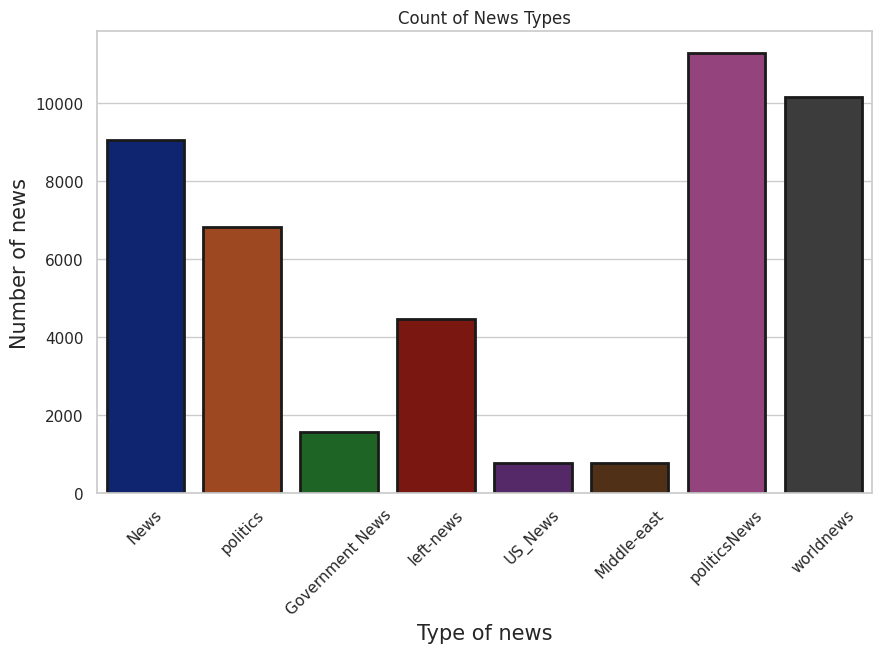

In [ ]:
# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# Customize the style for a white background with gridlines
sns.set(style="whitegrid")

# Plot the frequency plot
ax = sns.countplot(
    x="subject",              # Data for x-axis
    data=info_cleaned,        # Your data
    palette="dark",           # Color palette
    edgecolor="k",            # Edge color
    linewidth=2,              # Edge line width
)

# Add a title and customize font sizes
ax.set(
    xlabel='Type of news',    # X-axis label
    ylabel='Number of news',  # Y-axis label
    title='Count of News Types',  # Plot title
)

# Customize the font size of axis labels
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()


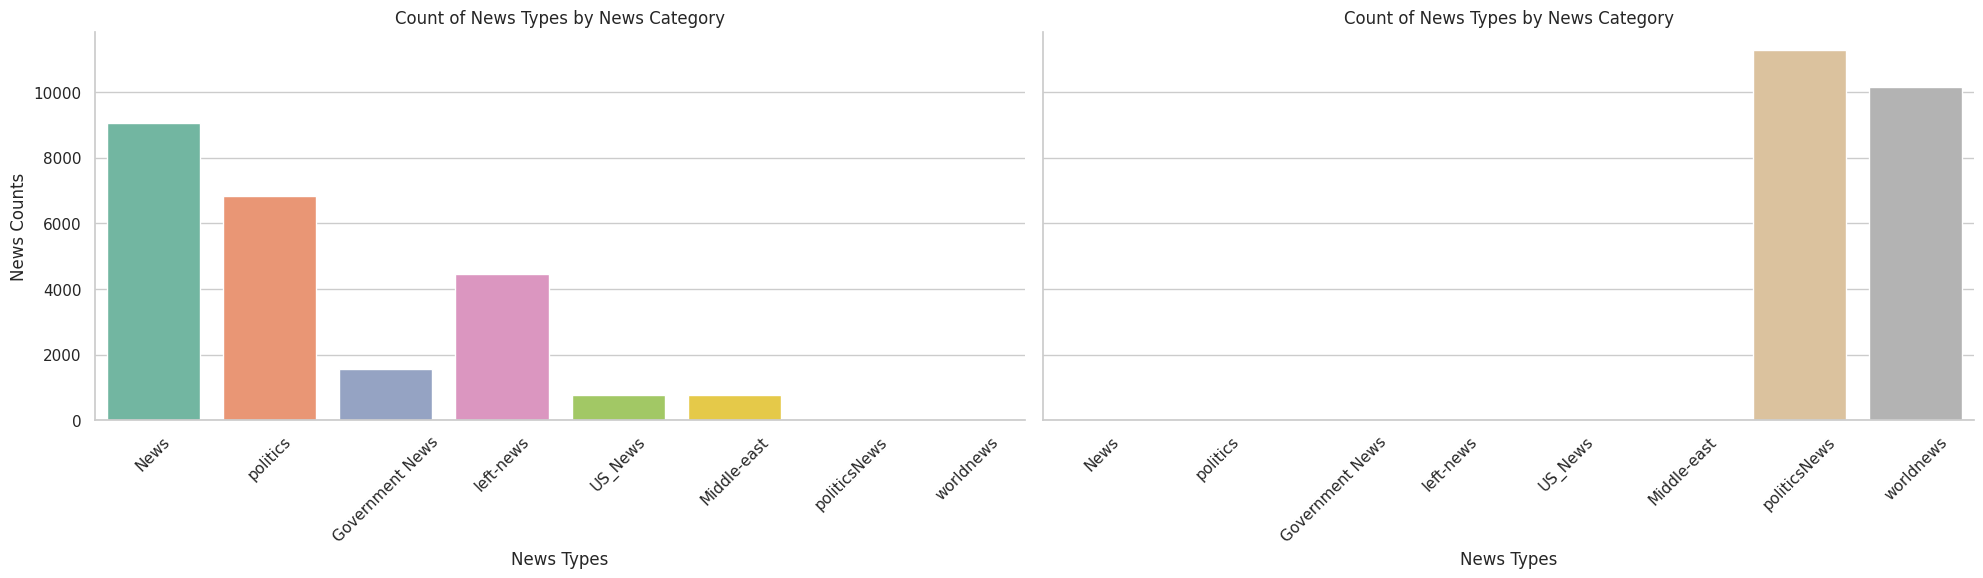

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# Create a catplot with a customized color palette
g = sns.catplot(
    x="subject",            # Data for x-axis
    col="target",           # Categorize by "target" column
    data=info_cleaned,      # Your data
    kind="count",           # Type of plot
    height=5,                # Height of each subplot
    aspect=2,               # Aspect ratio of each subplot
    palette="Set2"          # Custom color palette
)

# Customize the appearance
g.set(
    xlabel='News Types',       # X-axis label
    ylabel='News Counts',     # Y-axis label
    title='Count of News Types by News Category',  # Plot title
)

# Rotate x-axis labels for better readability
g.set_xticklabels(rotation=45)

# Show the plot
plt.show()


In [ ]:
info_cleaned['target'].value_counts()
# We see this is a balanced dataset

0    23471
1    21417
Name: target, dtype: int64

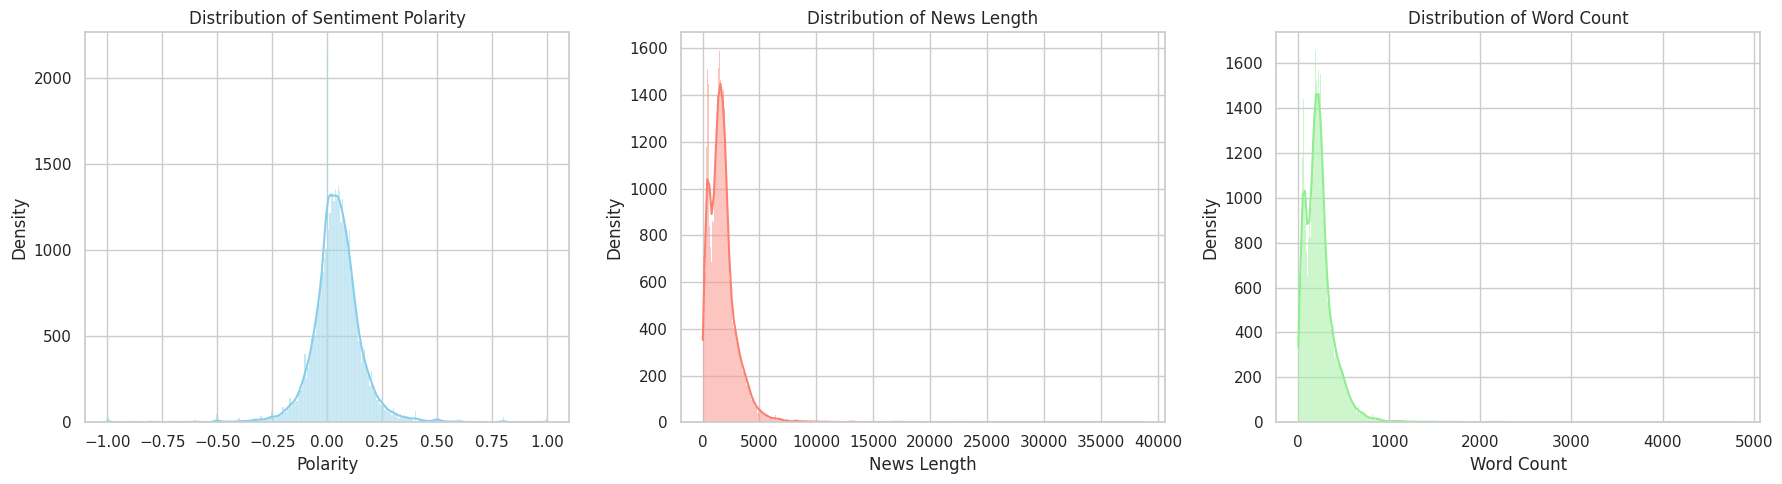

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Extract features from the 'news' column
info_cleaned['polarity'] = info_cleaned['news'].apply(lambda text: TextBlob(text).sentiment.polarity)
info_cleaned['news_len'] = info_cleaned['news'].astype(str).apply(len)
info_cleaned['word_count'] = info_cleaned['news'].apply(lambda x: len(str(x).split()))

# Create subplots with customized style
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.set(style="whitegrid")

# Plot the distribution of Polarity
sns.histplot(info_cleaned['polarity'], kde=True, color='skyblue', ax=axes[0])
axes[0].set(xlabel='Polarity', ylabel='Density', title='Distribution of Sentiment Polarity')

# Plot the distribution of Review Length
sns.histplot(info_cleaned['news_len'], kde=True, color='salmon', ax=axes[1])
axes[1].set(xlabel='News Length', ylabel='Density', title='Distribution of News Length')

# Plot the distribution of Word Count
sns.histplot(info_cleaned['word_count'], kde=True, color='lightgreen', ax=axes[2])
axes[2].set(xlabel='Word Count', ylabel='Density', title='Distribution of Word Count')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


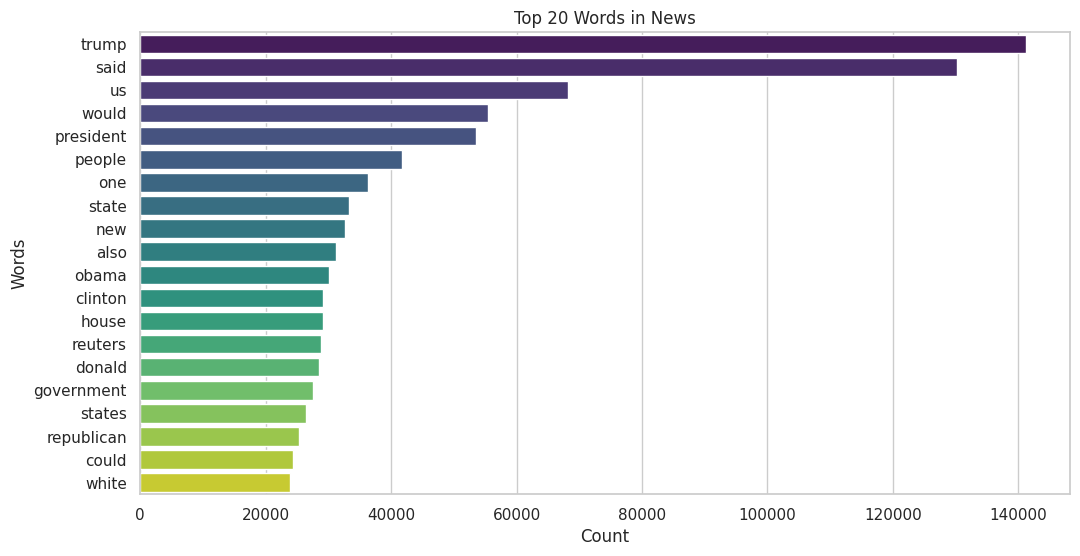

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import CountVectorizer

# Function to get the top n words
def top_words(corpus, n=20):
    # Initialize the CountVectorizer and fit it to the corpus
    vectorizer = CountVectorizer()
    word_matrix = vectorizer.fit_transform(corpus)

    # Get the sum of word frequencies
    word_frequencies = word_matrix.sum(axis=0)

    # Get the list of words and their corresponding frequencies
    words_freq = [(word, word_frequencies[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

    # Sort words by frequency in descending order
    words_freq.sort(key=lambda x: x[1], reverse=True)

    return words_freq[:n]

# Call the function to get the top 20 words
common_words = top_words(info_cleaned['news'])

# Create a DataFrame to store word and frequency
df1 = pd.DataFrame(common_words, columns=['word', 'frequency'])

# Plot the top 20 words
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=df1, palette='viridis')
plt.title('Top 20 Words in News')
plt.xlabel('Count')
plt.ylabel('Words')

# Show the plot
plt.show()


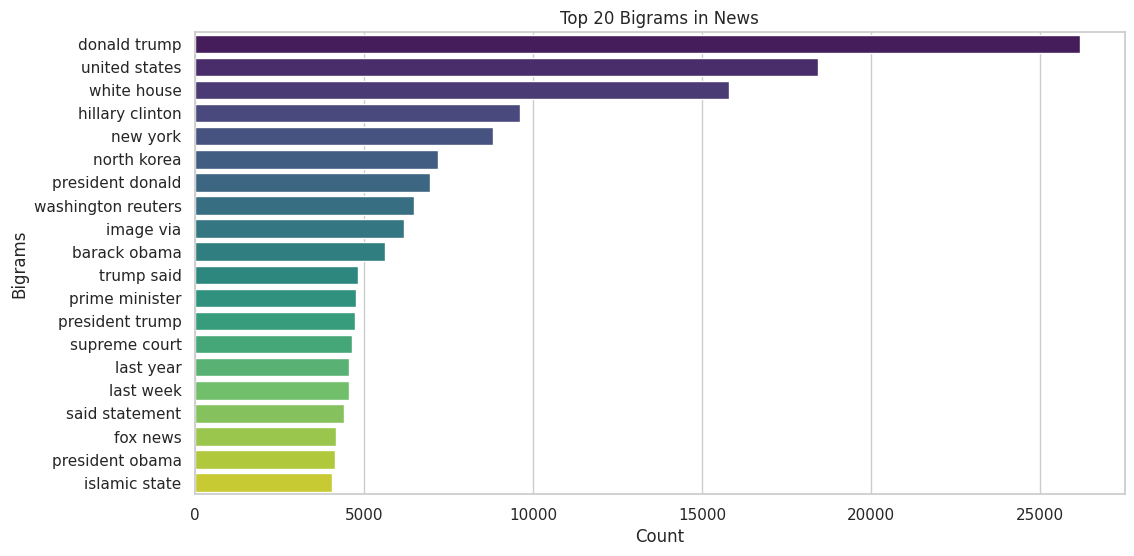

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import CountVectorizer

# Function to get the top n bigram words
def top_bigram(corpus, n=20):
    # Initialize the CountVectorizer with bigram range and fit it to the corpus
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    word_matrix = vectorizer.fit_transform(corpus)

    # Get the sum of bigram frequencies
    bigram_frequencies = word_matrix.sum(axis=0)

    # Get the list of bigrams and their corresponding frequencies
    bigrams_freq = [(bigram, bigram_frequencies[0, idx]) for bigram, idx in vectorizer.vocabulary_.items()]

    # Sort bigrams by frequency in descending order
    bigrams_freq.sort(key=lambda x: x[1], reverse=True)

    return bigrams_freq[:n]

# Call the function to get the top 20 bigram words
common_bigrams = top_bigram(info_cleaned['news'])

# Create a DataFrame to store bigram and frequency
df3 = pd.DataFrame(common_bigrams, columns=['bigram', 'frequency'])

# Plot the top 20 bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='bigram', data=df3, palette='viridis')
plt.title('Top 20 Bigrams in News')
plt.xlabel('Count')
plt.ylabel('Bigrams')

# Show the plot
plt.show()


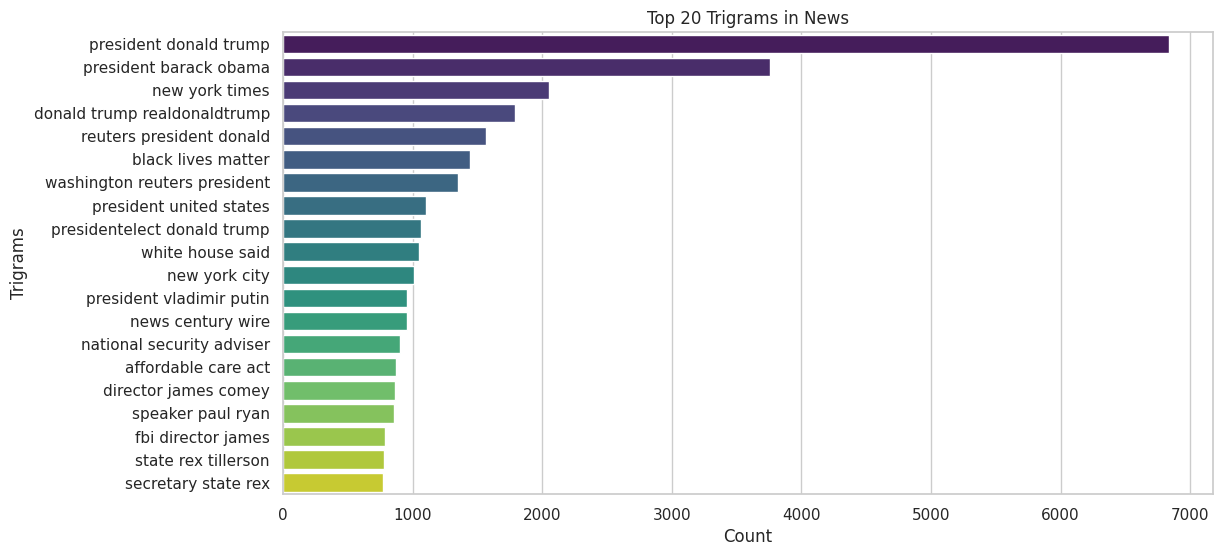

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import CountVectorizer

# Function to get the top n trigram words
def top_trigram(corpus, n=20):
    # Initialize the CountVectorizer with trigram range and stop words removal, and fit it to the corpus
    vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
    word_matrix = vectorizer.fit_transform(corpus)

    # Get the sum of trigram frequencies
    trigram_frequencies = word_matrix.sum(axis=0)

    # Get the list of trigrams and their corresponding frequencies
    trigrams_freq = [(trigram, trigram_frequencies[0, idx]) for trigram, idx in vectorizer.vocabulary_.items()]

    # Sort trigrams by frequency in descending order
    trigrams_freq.sort(key=lambda x: x[1], reverse=True)

    return trigrams_freq[:n]

# Call the function to get the top 20 trigram words
common_trigrams = top_trigram(info_cleaned['news'])

# Create a DataFrame to store trigram and frequency
df6 = pd.DataFrame(common_trigrams, columns=['trigram', 'frequency'])

# Plot the top 20 trigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='trigram', data=df6, palette='viridis')
plt.title('Top 20 Trigrams in News')
plt.xlabel('Count')
plt.ylabel('Trigrams')

# Show the plot
plt.show()


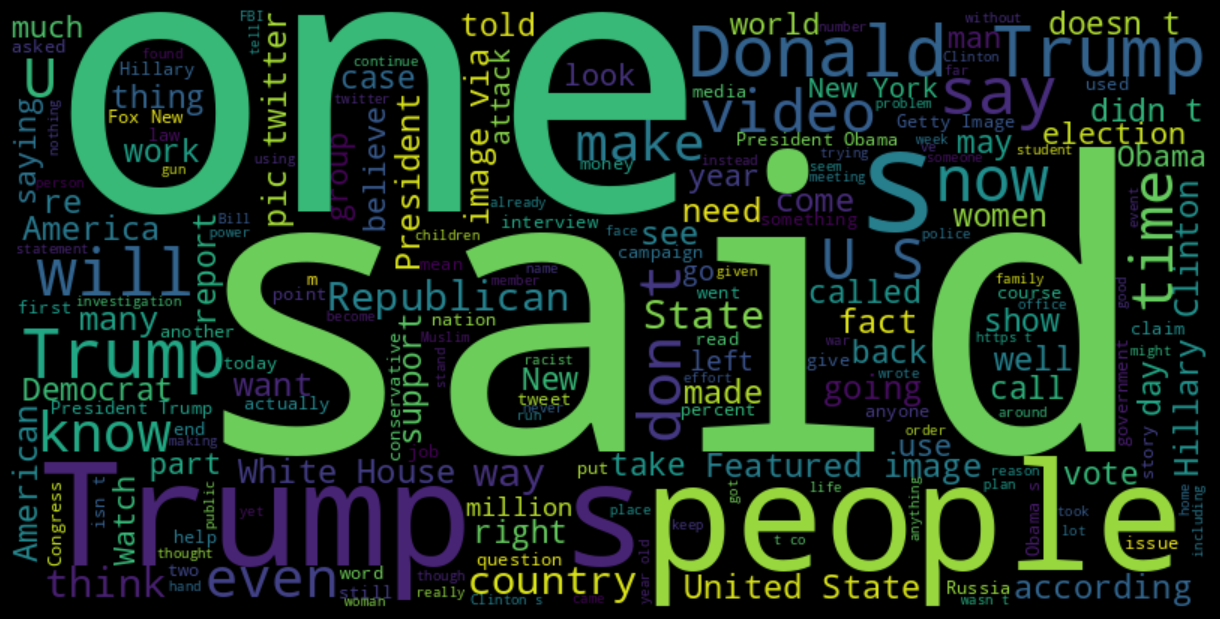

In [ ]:
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.pyplot as plt

# Concatenate the 'news' column into a single string
text = " ".join(news for news in fake_info["news"])

# Create a WordCloud object with customized parameters
wordcloud = WordCloud(
    width=800,                   # Width of the word cloud image
    height=400,                  # Height of the word cloud image
    background_color='black',    # Background color
    stopwords=STOPWORDS          # Stopwords to exclude
).generate(text)

# Create a plot with custom figsize and background color
plt.figure(figsize=(12, 6), facecolor='black')

# Display the word cloud image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')                # Turn off axis
plt.tight_layout(pad=0)        # Remove padding

# Show the word cloud
plt.show()


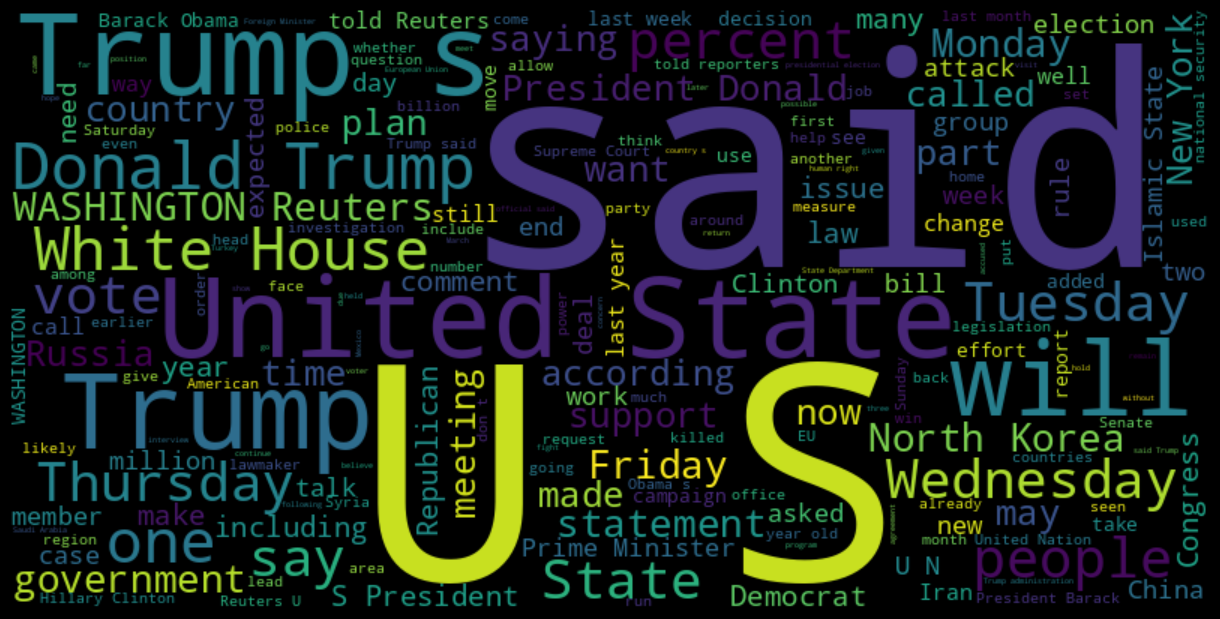

In [ ]:
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.pyplot as plt

# Concatenate the 'news' column into a single string
text = " ".join(news for news in true_info["news"])

# Create a WordCloud object with customized parameters
wordcloud = WordCloud(
    width=800,                   # Width of the word cloud image
    height=400,                  # Height of the word cloud image
    background_color='black',    # Background color
    stopwords=STOPWORDS          # Stopwords to exclude
).generate(text)

# Create a plot with custom figsize and background color
plt.figure(figsize=(12, 6), facecolor='black')

# Display the word cloud image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')                # Turn off axis
plt.tight_layout(pad=0)        # Remove padding

# Show the word cloud
plt.show()


In [ ]:
# fake_info.head()

In [ ]:
# import pandas as pd
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# Group by date and count the occurrences of 'target' for fake and true news
fake_counts = fake_info.groupby('date')['target'].count()
true_counts = true_info.groupby('date')['target'].count()

# Create a DataFrame for each group
fake_df = pd.DataFrame({'date': fake_counts.index, 'fake_count': fake_counts.values})
true_df = pd.DataFrame({'date': true_counts.index, 'true_count': true_counts.values})

# Create a subplot with shared x-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    subplot_titles=('Count of Fake News Over Time', 'Count of True News Over Time'))

# Add traces for fake and true news counts
fig.add_trace(go.Scatter(x=fake_df['date'], y=fake_df['fake_count'], mode='lines', name='Fake News', line=dict(color='red')))
fig.add_trace(go.Scatter(x=true_df['date'], y=true_df['true_count'], mode='lines', name='True News', line=dict(color='blue')))

# Update x-axis rangeslider and rangeselector
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
    buttons=list([
        dict(count=1, label="1m", step="month", stepmode="backward"),
        dict(count=6, label="6m", step="month", stepmode="backward"),
        dict(count=1, label="YTD", step="year", stepmode="todate"),
        dict(count=1, label="1y", step="year", stepmode="backward"),
        dict(step="all")
    ])
))

# Update layout with title and y-axis label
fig.update_layout(title_text='True and Fake News Over Time',
                  plot_bgcolor='rgb(248, 248, 255)',
                  yaxis=dict(title='Count'))

# Show the plot
fig.show()


##**Feature Engineering**

In [ ]:
# Extract the 'news' feature and create a new DataFrame
news_features = pd.DataFrame(info_cleaned['news'])

# Reset the index to start from 0
news_features.reset_index(drop=True, inplace=True)

# Display the first few rows of the extracted 'news' feature
news_features.head()


,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas spe...


In [ ]:
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

# Initialize stopwords and Porter Stemmer
stop_words = set(stopwords.words("english"))
ps = PorterStemmer()

# Preprocess the 'news' feature
corpus = []

for news_text in news_features['news']:
    # Remove non-alphabet characters and convert to lowercase
    news_text = re.sub('[^a-zA-Z]', ' ', news_text).lower()

    # Tokenize the text and apply stemming while excluding stopwords
    words = [ps.stem(word) for word in news_text.split() if word not in stop_words]

    # Rejoin the stemmed words
    stemmed_news = ' '.join(words)
    corpus.append(stemmed_news)

# Extract the target variable
y = info_cleaned['target']


In [ ]:
# #Setting up vocabulary size
voc_size=10000

#One hot encoding
onehot_vars = [hashing_trick(text=words, n=10_000, hash_function='md5') for words in corpus]

#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_vars,padding='pre',maxlen=sent_length)
print(embedded_docs)


[[   0    0    0 ... 5449  615  172]
 [   0    0    0 ... 1066 9817  172]
 [   0    0    0 ... 4044 9576  172]
 ...
 [   0    0    0 ... 1640 7585 4763]
 [   0    0    0 ... 3082 2560  261]
 [   0    0    0 ... 1596 8018 5609]]


## **LSTM**

### Modeling

In [ ]:
#Creating the lstm model
num_vars=40
model=Sequential()
model.add(Embedding(voc_size,num_vars,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(50))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
# model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['sparse_categorical_accuracy'])
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 50)                18200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 418251 (1.60 MB)
Trainable params: 418251 (1.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
len(embedded_docs),y.shape

(44888, (44888,))

In [ ]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 5000), (44888,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [ ]:
X_train.shape,X_test.shape

((30074, 5000), (14814, 5000))

In [ ]:
# y_train = y_train.ravel()
# y_test = y_test.ravel()

In [ ]:
# Fitting with 5 epochs and 32 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=32)

Epoch 1/5
940/940 [==============================] - 301s 310ms/step - loss: 0.1942 - accuracy: 0.9290 - val_loss: 0.0765 - val_accuracy: 0.9775
Epoch 2/5
940/940 [==============================] - 201s 214ms/step - loss: 0.0659 - accuracy: 0.9797 - val_loss: 0.0658 - val_accuracy: 0.9812
Epoch 3/5
940/940 [==============================] - 213s 227ms/step - loss: 0.0353 - accuracy: 0.9898 - val_loss: 0.0417 - val_accuracy: 0.9890
Epoch 4/5
940/940 [==============================] - 179s 190ms/step - loss: 0.0222 - accuracy: 0.9936 - val_loss: 0.0164 - val_accuracy: 0.9965
Epoch 5/5
940/940 [==============================] - 163s 173ms/step - loss: 0.0543 - accuracy: 0.9829 - val_loss: 0.0954 - val_accuracy: 0.9706


In [ ]:
# model.save
model.save('/content/drive/MyDrive/data/models/model_lstm/lstm.h5')
# model load
#model = load_model("/content/drive/MyDrive/data/models/model_lstm/lstm.h5")


### Performance Metrics

In [ ]:
predict_x=model.predict(X_test)
y_pred = (predict_x > 0.5).astype("int32")

463/463 [==============================] - 32s 58ms/step


In [ ]:
print(accuracy_score(y_test,y_pred))
model.summary()
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

0.9705683812609693
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 50)                18200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 418251 (1.60 MB)
Trainable params: 418251 (1.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

In [ ]:
predict_x.ravel()


array([2.7261686e-03, 9.8233092e-01, 4.7439004e-05, ..., 2.5351041e-05,
       6.1901830e-02, 9.5100504e-01], dtype=float32)

(0.0, 1.05)

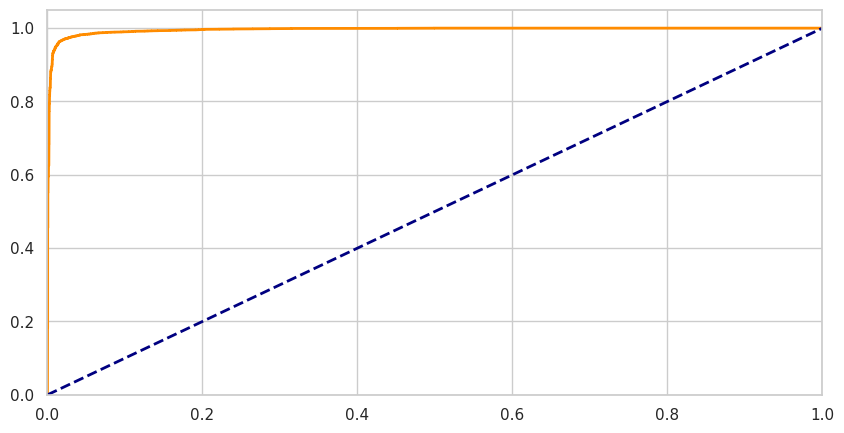

In [ ]:


# Assuming 'predict_x' contains your model's predicted probabilities for class 1
fpr, tpr, thresholds = roc_curve(y_test, predict_x.ravel())

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

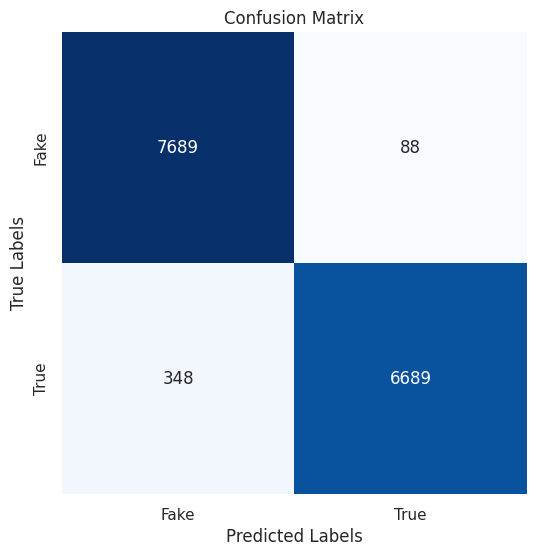

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels for better visualization
class_labels = ['Fake', 'True']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [ ]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.9705683812609693
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7777
           1       0.99      0.95      0.97      7037

    accuracy                           0.97     14814
   macro avg       0.97      0.97      0.97     14814
weighted avg       0.97      0.97      0.97     14814



In [ ]:
model_l = load_model("/content/drive/MyDrive/data/models/model_lstm/lstm.h5")

In [ ]:
predict_l_x=model_l.predict(X_test)
y_pred_l = (predict_l_x > 0.5).astype("int32")

463/463 [==============================] - 25s 53ms/step


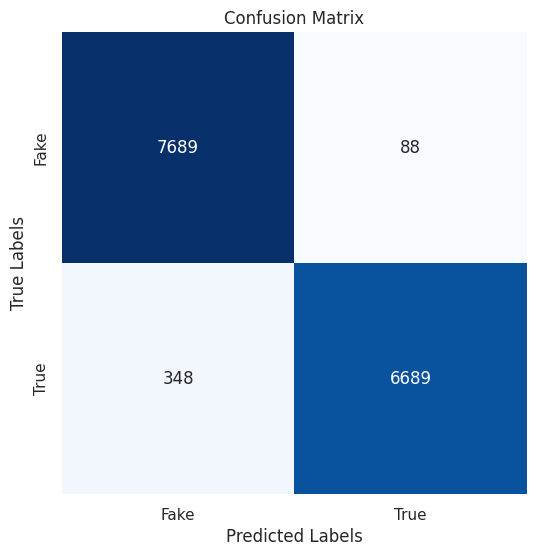

In [ ]:
# Calculate the confusion matrix
cm_l = confusion_matrix(y_test, y_pred_l)

# Define class labels for better visualization
class_labels = ['Fake', 'True']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_l, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [ ]:
#Checking for accuracy
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred_l))

0.9705683812609693


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

463/463 [==============================] - 27s 59ms/step - loss: 0.0954 - accuracy: 0.9706
Accuracy: 0.9705683588981628


## **XGBOOST**

### Modeling

In [ ]:
# import xgboost as xgb
X_train.shape,y_test

((30074, 5000), array([0, 1, 0, ..., 0, 1, 1]))

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
# save model
xgb_model.save_model("/content/drive/MyDrive/data/models/model_lstm/xgb_modelv3.txt")
# load model
# xbg_model = xgb.XGBRegressor()
# xbg_model.load_model("/content/drive/MyDrive/data/models/model_lstm/xgb_modelv3.txt")

### Performance Metrics

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

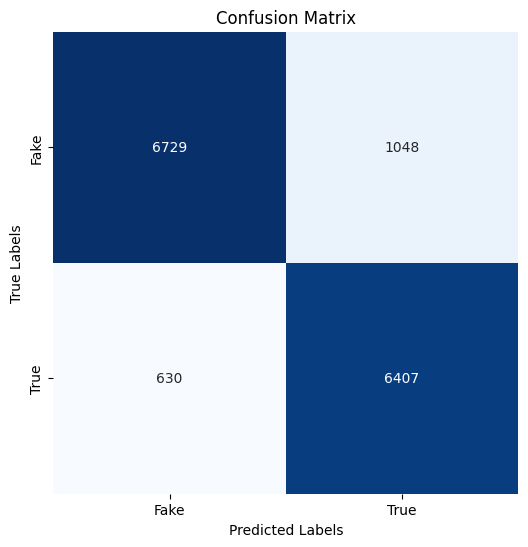

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Define class labels for better visualization
class_labels = ['Fake', 'True']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
y_pred_xgb_prob = xgb_model.predict_proba(X_test)


Text(0, 0.5, 'True Positive Rate')

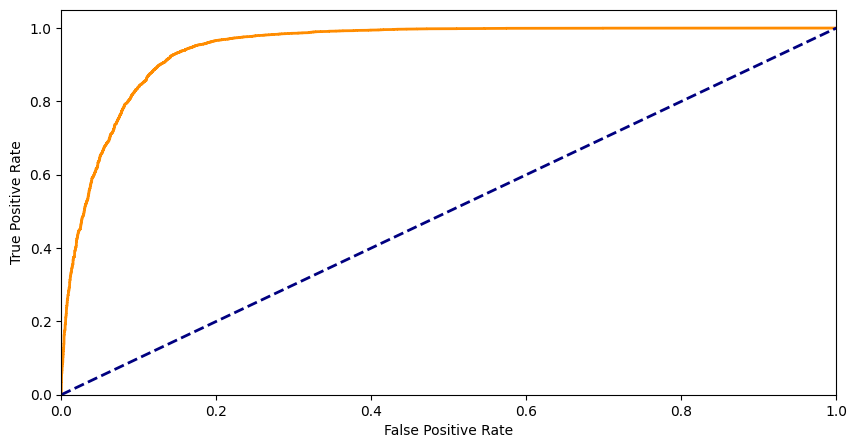

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_pred_xgb_prob contains the predicted probabilities for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb_prob[:, 1])

# Calculate the area under the ROC curve (AUC)
roc_auc = roc_auc_score(y_test, y_pred_xgb_prob[:, 1])

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
#Checking for accuracy
print(accuracy_score(y_test,y_pred_xgb))
print(classification_report(y_test,y_pred_xgb))

0.8893614148778183
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      7777
           1       0.86      0.92      0.89      7037

    accuracy                           0.89     14814
   macro avg       0.89      0.89      0.89     14814
weighted avg       0.89      0.89      0.89     14814



## **Randomforest**

### Modeling

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

In [ ]:

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 500)

# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)



RandomForestClassifier(n_estimators=500)

### Performance Metrics

In [ ]:
# performing predictions on the test dataset
y_pred_rf = clf.predict(X_test)

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Define class labels for better visualization
class_labels = ['Fake', 'True']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [ ]:
#Checking for accuracy
print(accuracy_score(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))

0.7725799918995545
              precision    recall  f1-score   support

           0       0.75      0.84      0.80      7777
           1       0.80      0.70      0.74      7037

    accuracy                           0.77     14814
   macro avg       0.78      0.77      0.77     14814
weighted avg       0.78      0.77      0.77     14814



In [ ]:
# This is not being used as this contains more resources and I will be running out of the colabs free allocated resource limits.
# model_grid = RandomForestClassifier(max_depth=9,
#                                     max_features="log2",
#                                     max_leaf_nodes=9,
#                                     n_estimators=25)
# model_grid.fit(X_train, y_train)
# y_pred_grid = model.predict(X_test)
# print(classification_report(y_pred_grid, y_test))

In [ ]:
# #Checking for accuracy
# print(accuracy_score(y_test,y_pred_grid))
# # print(classification_report(y_test,y_pred_grid))

## **Scoring**

In [ ]:

lstm_model_l = load_model("/content/drive/MyDrive/data/models/model_lstm/lstm.h5")

In [ ]:
def news_cleaning(raw_text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    raw_text = str(raw_text).lower()
    raw_text = re.sub('\[.*?\]', '', raw_text)
    raw_text = re.sub('https?://\S+|www\.\S+', '', raw_text)
    raw_text = re.sub('<.*?>+', '', raw_text)
    raw_text = re.sub('[%s]' % re.escape(string.punctuation), '', raw_text)
    raw_text = re.sub('\n', '', raw_text)
    raw_text = re.sub('\w*\d\w*', '', raw_text)
    return raw_text

In [ ]:
news="""'A New England Patriots fan didn't suffer from "traumatic" injuries when he collapsed at a game and later died, officials said Wednesday, suggesting his death may not be linked to a fight at the stadium.

Dale Mooney, a 53-year-old New Hampshire resident, fell unconscious in the fourth quarter of New England's "Sunday Night Football" game against the Miami Dolphins in the upper deck of Gillette Stadium in Foxborough and could not be revived, officials said.

'"""

In [ ]:
news_to_clean=news_cleaning(news)

In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
psl = PorterStemmer()

In [ ]:
corpus1=[]
news = re.sub('[^a-zA-Z]', ' ', news_to_clean)
news= news.lower()
news = news.split()
news = [psl.stem(word) for word in news if not word in stop]
news = ' '.join(news)
corpus1.append(news)#Getting the target variable

In [ ]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding
onehot_vars_l = [hashing_trick(text=words, n=10_000, hash_function='md5') for words in corpus1]

#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs_l=pad_sequences(onehot_vars_l,padding='pre',maxlen=sent_length)
print(embedded_docs_l)

[[   0    0    0 ... 1494 2067 4763]]


In [ ]:
X_score=np.array(embedded_docs_l)


In [ ]:
y_pred_s = lstm_model_l.predict(embedded_docs_l)

1/1 [==============================] - 0s 404ms/step


In [ ]:
news_class = (y_pred_s > 0.5).astype("int32")
news_class

array([[1]], dtype=int32)